In [4]:
# -----------------------------------------------------------------------------------------------------------------------
# Author: Ranjan Barman and dhrubas2
# Date: Jul 15, 2025
# Title: nuHIFs-based CoxPH Survival Analysis for BRCA Subtypes (HER2+, HR+, TNBC)
# Models: (2) All nuHIFs + Age (collinearity removal before CV, fold-wise normalization, Age not scaled)
# -----------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Set working directory
_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)

# Input/output paths
dataset_name = "TCGA_BRCA_FFPE"
data_file = f"{dataset_name}/outputs/PathAI/Survival_V2/BrcaBiomarkerStatusToPathAI_nuHIFsToSurvival.csv"
output_dir = os.path.join("/data/Ruppin_AI/BRCA_PIF/Ranjan/DataForFigures/Survival_V2", "nuHIFs")
os.makedirs(output_dir, exist_ok=True)

# Load data
data = pd.read_csv(data_file)

# Use column names of nuHIFs (90 features only)
nuHIFs = data.columns[5:95].tolist()
print("Total number of nuHIFs:", len(nuHIFs))

nuHIFs

# Subtype filtering
tn = data[(data['HER2_Status'] == 'Negative') & (data['ER_Status'] == 'Negative') & (data['PR_Status'] == 'Negative')].copy()
her2 = data[data['HER2_Status'] == 'Positive'].copy()
hr = data[((data['ER_Status'] == 'Positive') | (data['PR_Status'] == 'Positive')) & (data['HER2_Status'] != 'Positive')].copy()

# Fixed-threshold collinearity removal function (0.8)
def remove_highly_correlated_features_fixed(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    retained_features = df.drop(columns=drop_cols).columns.tolist()
    return retained_features

# Main CV function
def coxph_5fold_cv_combined_km(df, subtype_name, feature_cols, survival_type='os', outputs_path=None):
    covariates = feature_cols + ['Age']
    time_col = f'{survival_type}_time'
    event_col = survival_type

    required_cols = covariates + ['sample_id', 'os_time', 'os', 'pfs_time', 'pfs']
    df = df[required_cols].dropna().copy()
    df['Subtype'] = subtype_name

    full_original = df.copy()
    df = df.rename(columns={time_col: 'Time', event_col: 'Event'})

    max_retry = 100
    for retry in range(max_retry):
        kf = KFold(n_splits=5, shuffle=True, random_state=42 + retry)
        folds = list(kf.split(df))
        if all(df.iloc[test]['Event'].sum() > 0 for _, test in folds):
            break
    else:
        print(f"No valid CV split for {subtype_name} ({survival_type})")
        return None

    combined_df = []

    for fold_num, (train_idx, test_idx) in enumerate(folds, 1):
        train = df.iloc[train_idx].copy()
        test = df.iloc[test_idx].copy()

        try:
            train_covariates = train[feature_cols].copy()
            test_covariates = test[feature_cols].copy()

            # Scale nuHIFs only
            scaler = MinMaxScaler()
            train_scaled = scaler.fit_transform(train_covariates)
            test_scaled = scaler.transform(test_covariates)

            train_df = pd.DataFrame(train_scaled, columns=feature_cols, index=train.index)
            test_df = pd.DataFrame(test_scaled, columns=feature_cols, index=test.index)

            train_df['Age'] = train['Age'].values
            train_df['Time'] = train['Time'].values
            train_df['Event'] = train['Event'].values
            test_df['Age'] = test['Age'].values

            cph = CoxPHFitter()
            cph.fit(train_df, duration_col='Time', event_col='Event')

            test_risk = cph.predict_partial_hazard(test_df)

            original_test_info = full_original.iloc[test_idx].copy()
            original_test_info[f"risk_score_{survival_type}"] = test_risk.values
            original_test_info['Fold'] = fold_num
            combined_df.append(original_test_info)

        except Exception as e:
            print(f"Fold {fold_num} failed for {subtype_name} ({survival_type}): {str(e)}")
            continue

    if not combined_df:
        print(f"All folds failed for {subtype_name} ({survival_type})")
        return None

    combined_df = pd.concat(combined_df, axis=0)
    return combined_df

# Merge helper
def merge_os_pfs(os_df, pfs_df):
    if os_df is None or pfs_df is None:
        print("Skipping merge due to missing input.")
        return None
    return pd.merge(
        os_df[['sample_id', 'os_time', 'os', 'Age', 'risk_score_os', 'Subtype']],
        pfs_df[['sample_id', 'pfs_time', 'pfs', 'risk_score_pfs']],
        on='sample_id', how='outer'
    )

# Apply fixed-threshold collinearity filtering before CV per subtype
her2_nuhifs = remove_highly_correlated_features_fixed(her2[nuHIFs], threshold=0.8)
print(f"[HER2+ | Pre-CV] Fixed threshold = 0.80, Features retained = {len(her2_nuhifs)}")
print(f"[HER2+ | Retained Features] {her2_nuhifs}\n")

hr_nuhifs = remove_highly_correlated_features_fixed(hr[nuHIFs], threshold=0.8)
print(f"[HR+ | Pre-CV] Fixed threshold = 0.80, Features retained = {len(hr_nuhifs)}")
print(f"[HR+ | Retained Features] {hr_nuhifs}\n")

tnbc_nuhifs = remove_highly_correlated_features_fixed(tn[nuHIFs], threshold=0.8)
print(f"[TNBC | Pre-CV] Fixed threshold = 0.80, Features retained = {len(tnbc_nuhifs)}")
print(f"[TNBC | Retained Features] {tnbc_nuhifs}\n")

# Run survival analysis with filtered nuHIFs
her2_os_df   = coxph_5fold_cv_combined_km(her2, 'HER2+', her2_nuhifs, 'os', output_dir)
her2_pfs_df  = coxph_5fold_cv_combined_km(her2, 'HER2+', her2_nuhifs, 'pfs', output_dir)

hr_os_df     = coxph_5fold_cv_combined_km(hr, 'HR+', hr_nuhifs, 'os', output_dir)
hr_pfs_df    = coxph_5fold_cv_combined_km(hr, 'HR+', hr_nuhifs, 'pfs', output_dir)

tnbc_os_df   = coxph_5fold_cv_combined_km(tn, 'TNBC', tnbc_nuhifs, 'os', output_dir)
tnbc_pfs_df  = coxph_5fold_cv_combined_km(tn, 'TNBC', tnbc_nuhifs, 'pfs', output_dir)

# Merge results
her2_combined = merge_os_pfs(her2_os_df, her2_pfs_df)
hr_combined   = merge_os_pfs(hr_os_df, hr_pfs_df)
tnbc_combined = merge_os_pfs(tnbc_os_df, tnbc_pfs_df)

combined_list = [df for df in [her2_combined, hr_combined, tnbc_combined] if df is not None]
combined_all = pd.concat(combined_list, axis=0)
final_csv = os.path.join(output_dir, "All_Subtypes_AllSurvival_Combined_TestSamples_nuHIFs.csv")
combined_all.to_csv(final_csv, index=False)


Total number of nuHIFs: 90
[HER2+ | Pre-CV] Fixed threshold = 0.80, Features retained = 28
[HER2+ | Retained Features] ['MEAN[CANCER_NUCLEUS_AREA]_H & E', 'MEAN[CANCER_NUCLEUS_CIRCULARITY]_H & E', 'MEAN[CANCER_NUCLEUS_MEAN_LAB_CHANNEL_A]_H & E', 'MEAN[CANCER_NUCLEUS_MEAN_LAB_CHANNEL_B]_H & E', 'MEAN[CANCER_NUCLEUS_MIN_GRAYSCALE_CHANNEL_GRAY]_H & E', 'MEAN[CANCER_NUCLEUS_MIN_HSV_CHANNEL_SATURATION]_H & E', 'MEAN[CANCER_NUCLEUS_STD_GRAYSCALE_CHANNEL_GRAY]_H & E', 'MEAN[CANCER_NUCLEUS_STD_HSV_CHANNEL_SATURATION]_H & E', 'MEAN[CANCER_NUCLEUS_STD_LAB_CHANNEL_A]_H & E', 'MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E', 'MEAN[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E', 'MEAN[FIBROBLAST_NUCLEUS_STD_GRAYSCALE_CHANNEL_GRAY]_H & E', 'MEAN[LYMPHOCYTE_NUCLEUS_AREA]_H & E', 'MEAN[LYMPHOCYTE_NUCLEUS_CIRCULARITY]_H & E', 'STD[CANCER_NUCLEUS_ECCENTRICITY]_H & E', 'STD[CANCER_NUCLEUS_MEAN_LAB_CHANNEL_A]_H & E', 'STD[CANCER_NUCLEUS_MEAN_LAB_CHANNEL_B]_H & E', 'STD[CANCER_NUCLEUS_MIN_GRAYSCALE_CHANNEL_GRAY]_H & E', 'STD

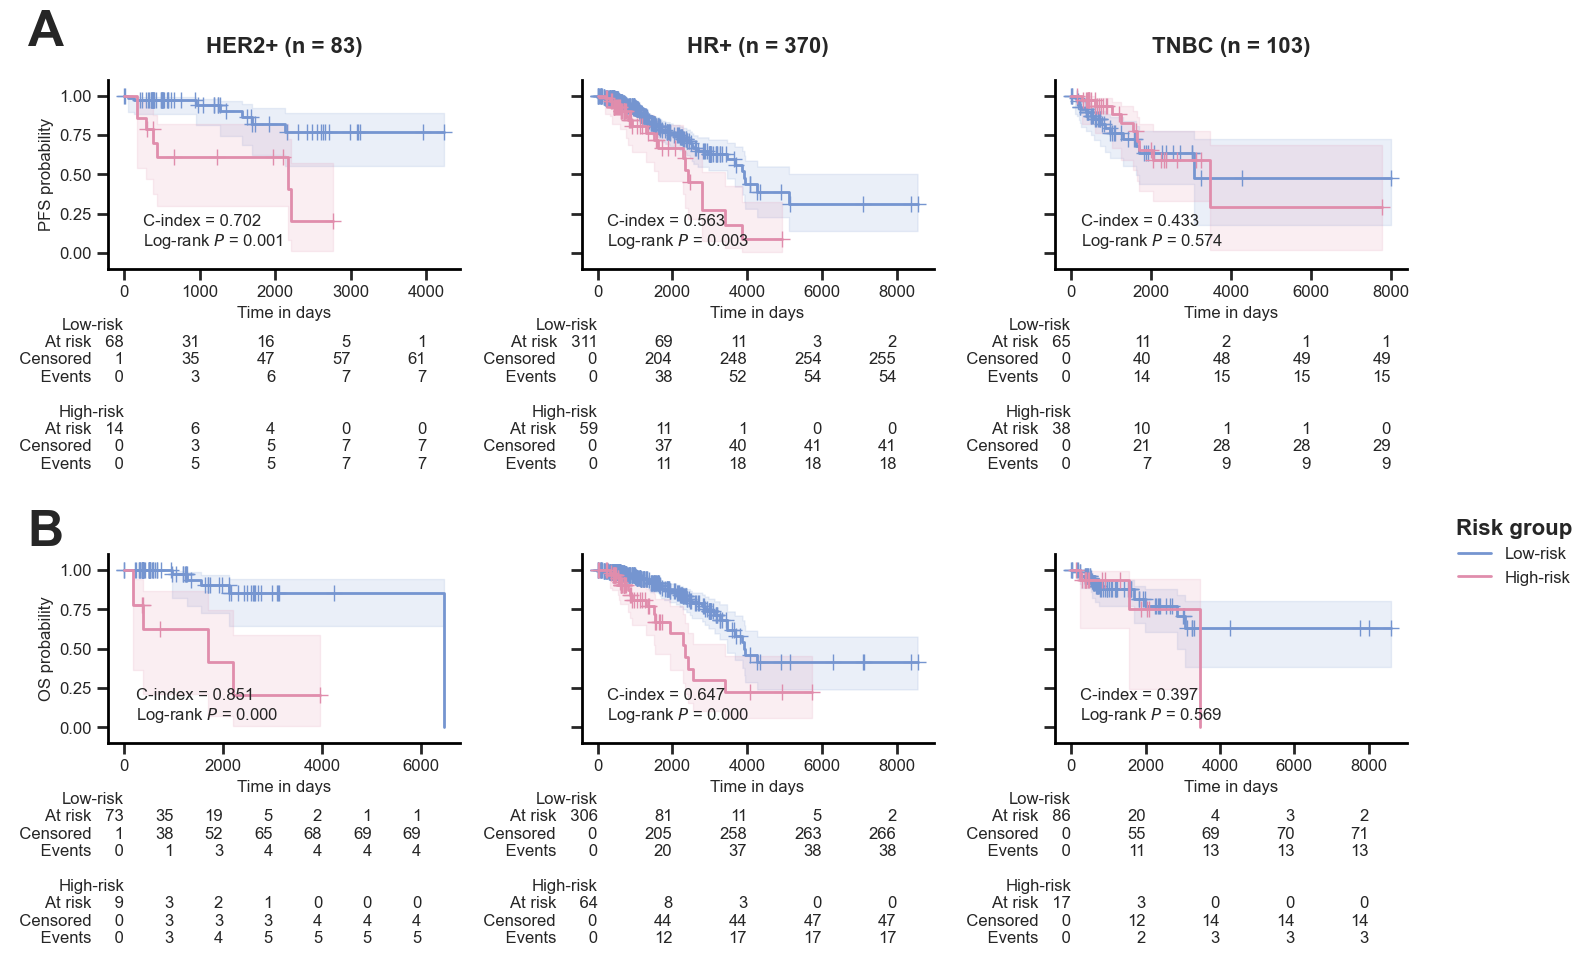

'/data/Ruppin_AI/BRCA_PIF/Ranjan/DataForFigures/Survival_V2/nuHIFs/All_Subtypes_AllSurvival_Combined_TestSamples_nuHIFs.csv'

In [5]:
# Load combined for plotting
data_surv = pd.read_csv(final_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index

def normalize(x, q=0.1):
    qq = np.quantile(x, q=[q, 1 - q])
    xx = (x - qq[0]) / (qq[1] - qq[0])
    xx[xx < 0] = 0
    xx[xx > 1] = 1
    return xx

surv_grps = ["Low-risk", "High-risk"]
group_th = 0.5
norm_qq = 0.10
subtypes = np.unique(data_surv.Subtype)

fig_data5, fig_stat5 = {}, {}
for surv in ["os", "pfs"]:
    km_data = data_surv[["Subtype", f"risk_score_{surv}", surv, f"{surv}_time"]].copy()
    km_data["risk_score"] = normalize(km_data[f"risk_score_{surv}"], q=norm_qq)
    for sb in subtypes:
        km_grp = km_data[km_data.Subtype == sb].copy()
        km_grp["group"] = km_grp["risk_score"].apply(lambda x: surv_grps[int(x >= group_th)])
        km_grp = km_grp.groupby("group", observed=False).apply(lambda df: df)

        fig_data5[f"{surv}-{sb}"] = {
            grp: KaplanMeierFitter().fit(
                durations=km_grp.loc[grp, f"{surv}_time"],
                event_observed=km_grp.loc[grp, surv],
                label=grp
            )
            for grp in surv_grps
        }

        fig_stat5[f"{surv}-{sb}"] = {
            "Cidx": concordance_index(
                event_times=km_data.loc[km_data.Subtype == sb, f"{surv}_time"],
                event_observed=km_data.loc[km_data.Subtype == sb, surv],
                predicted_scores=-km_data.loc[km_data.Subtype == sb, "risk_score"]
            ),
            "pval": logrank_test(
                durations_A=km_grp.loc[surv_grps[0], f"{surv}_time"],
                event_observed_A=km_grp.loc[surv_grps[0], surv],
                durations_B=km_grp.loc[surv_grps[1], f"{surv}_time"],
                event_observed_B=km_grp.loc[surv_grps[1], surv]
            ).p_value
        }

import matplotlib.pyplot as plt

#%% make fig 5.

sns.set_style("ticks")
plt.rcParams.update({
    "xtick.major.size": 8, "xtick.major.width": 2, 
    "ytick.major.size": 8, "ytick.major.width": 2, 
    "xtick.bottom": True, "ytick.left": True, 
    "axes.spines.top": False, "axes.spines.right": False, 
    "axes.linewidth": 2, "axes.edgecolor": "#000000", 
    "grid.linewidth": 1, "grid.color": "#000000", "grid.alpha": 0.8, 
    "legend.frameon": False, "legend.edgecolor": "#000000", 
    "legend.framealpha": 0.9, "legend.markerscale": 1.2, 
    "font.family": "sans"})

colors     = ["#E08DAC", "#7595D0", "#75D0B0", "#B075D0", "#C3D075", 
              "#FFC72C", "#708090", "#A9A9A9", "#000000"]
colors     = colors[:2][::-1]

fontdict   = {"label": {"size": 12, "weight": "regular"}, 
              "sbttl": {"size": 14, "weight": "bold"}, 
              "title": {"size": 16, "weight": "bold"}, 
              "super": {"size": 20, "weight": "bold"}, 
              "panel": {"size": 36, "weight": "bold"}}

lineprop   = {"ls": "-", "lw": 2}

fig_llocs5 = [0.96, 0.46]

fig5, ax5 = plt.subplots(figsize = (16, 10), nrows = 2, ncols = 3, sharey = True)
# ax5 = dict(zip([["A1", "A2", "A3"], ["B1", "B2", "B3"]], ax5))

for i, (surv, lbl) in enumerate(zip(["pfs", "os"], ["A", "B"])):
    for j, sb in enumerate(subtypes):
        dat, stat = fig_data5[f"{surv}-{sb}"], pd.Series(fig_stat5[f"{surv}-{sb}"])
        ax = ax5[i, j]
        for k, (grp, mdl) in enumerate(dat.items()):
            ax = mdl.plot(show_censors = True, ci_show = True, color = colors[k], 
                          ci_alpha = 0.15, ax = ax, **lineprop)
        ax.text(x = 250, y = 0.05, 
                s = f"C-index = {stat.Cidx:0.3f}\nLog-rank $P$ = {stat.pval:0.3f}", 
                **fontdict["label"]);
        add_at_risk_counts(*dat.values(), labels = list(dat.keys()), 
                           rows_to_show = None, ax = ax, **fontdict["label"]);
        sns.despine(ax = ax, offset = 0, trim = False);

        ax.set_ylim([-0.1, 1.1]);
        ax.tick_params(axis = "both", labelsize = fontdict["label"]["size"]);
        if (i, j) == (1, 2):
            ax.legend(loc = (1.12, 0.8), title = "Risk group", prop = fontdict["label"], 
                      title_fontproperties = fontdict["title"])
        else:
            ax.legend([ ], [ ]);

        ax.set_xlabel("Time in days", y = 0.025, **fontdict["label"]);
        if j == 0:
            ax.set_ylabel(f"{surv.upper()} probability", x = 0.025, **fontdict["label"]);
        
        if i == 0:
            ax.set_title(f"{sb} (n = {data_surv.Subtype.eq(sb).sum():,})", wrap = True, 
                         y = 1.1, **fontdict["title"]);

    fig5.text(x = 0.02, y = fig_llocs5[i], s = lbl, **fontdict["panel"]);


fig5.tight_layout(h_pad = 2)
plt.show()
final_csv

In [6]:
data_surv

,sample_id,os_time,os,Age,risk_score_os,Subtype,pfs_time,pfs,risk_score_pfs
0,TCGA-D8-A1X5,565,0,81,3.426649,HER2+,565,0,1.708314
1,TCGA-D8-A27W,373,0,55,0.502795,HER2+,373,0,1.590813
2,TCGA-D8-A1JB,1688,0,54,3.153444,HER2+,1688,0,1.180085
3,TCGA-AR-A0TX,1972,0,64,4.042181,HER2+,1972,0,4.566984
4,TCGA-E9-A22D,1248,0,38,1.721073,HER2+,1248,0,1.260734
...,...,...,...,...,...,...,...,...,...
551,TCGA-D8-A27M,410,0,59,1.621262,TNBC,410,0,0.000033
552,TCGA-AR-A0TU,709,0,35,0.759702,TNBC,709,0,0.624135
553,TCGA-D8-A1JL,611,0,72,0.467610,TNBC,611,0,0.003723
554,TCGA-BH-A1EW,1694,1,38,0.442070,TNBC,1694,1,1370.174637
